# Ecuaciones de FitzHugh-Nagumo

El modelo de FitzHugh - Nagumo (FHN) describe un prototipo de sistema excitable como una neurona.  Toma su nombre de Richard FitzHugh (1922 - 2007), quien propuso el modelo teórico en 1961, así como de J. Nagumo y otros, que construyeron un circuito electrónico equivalente.

$$ \dfrac{dv}{dt} = v - \dfrac{v^3}{3}-w+RI_{\text{ext}} $$
$$\tau \dfrac{dw}{dt} = v + a - bw $$

Aquí el parámetro a variar es $I_{\text{ext}}$ para analizar los diagramas de bifurcación y los puntos de estabilidad.



In [693]:
R = 1.0
a = 0.7
b = 0.8
τ = 12.5;

Para linealizar las ecuaciones, buscamos los casos donde $\dfrac{dv}{dt} = 0$ y $\dfrac{dw}{dt} = 0$. Entonces

$$v - \dfrac{v^3}{3}-w+RI_{\text{ext}} = 0 \Rightarrow w = v - \dfrac{v^3}{3} +RI_{\text{ext}} $$
$$v + a - bw = 0 \Rightarrow w = \dfrac{v + a}{b}$$

Tenemos una curva y una recta intersectando. Esa intersección la encontramos con el método de Newton-Raphson. Aquí, llamaremos la isoclina cúbica a $w = v - \dfrac{v^3}{3} +RI_{\text{ext}}$ y la isoclina lineal a $w = \dfrac{v + a}{b}$.

In [669]:
using LinearAlgebra, Plots

In [717]:
isoclina_cubica(v,I_ext) = -v^3/3 + v + R*I_ext
isoclina_lineal(v) = (v + a) / b
f(v,I_ext) = -v^3/3 +(1-1/b)*v + R*I_ext - a/b #isoclina_cubica - isoclina_lineal
df(v) = -v^2 + 1 - 1/b;

In [718]:
function NewtonRaphson(f, df, I_ext, v0; tol=1e-16, max = 1000)
    v = v0
    w = f(v0,I_ext)
    i = 0
    while abs(w) > tol && i < max
        v = v  - w/df(v)
        w = f(v,I_ext)
        i += 1
    end
    return v
end

NewtonRaphson (generic function with 4 methods)

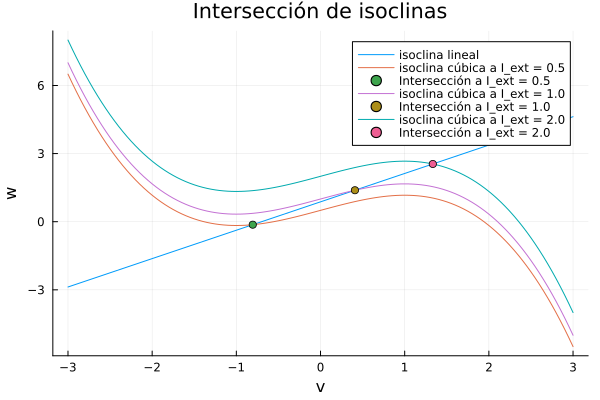

In [719]:
V = -3:0.05:3
I_list = [0.5,1.0,2.0]
intersecciones = plot(V,isoclina_lineal.(V), label = "isoclina lineal",ylabel = "w", xlabel ="v", title ="Intersección de isoclinas")

for i in I_list
    v_cero = NewtonRaphson(f, df, i, 0.0 ; tol=1e-16, max = 1000)
    plot!(V,isoclina_cubica.(V,i), label = "isoclina cúbica a I_ext = $(i)")
    scatter!((v_cero,isoclina_lineal(v_cero)), label = "Intersección a I_ext = $(i)")
end

savefig(intersecciones, "intersecciones.png")
display(intersecciones)
    

Ahora, llamamos $(v^{*},w^{*})$ al punto donde ambas derivadas se hacen cero, es decir, 

$$f(v^{*},w^{*}) = \dfrac{dv}{dt}(v^{*},w^{*}) = 0$$
$$g(v^{*},w^{*}) = \dfrac{dw}{dt}(v^{*},w^{*}) = 0$$

Hacemos un desarrollo de Taylor de este punto.

$$f(v,w) = f(v^{*},w^{*}) + \left.\dfrac{\partial f}{\partial v}\right|_{(v^{*},w^{*})}(v - v^{*}) + \left.\dfrac{\partial f}{\partial w}\right|_{(v^{*},w^{*})}(w - w^{*}) + ...$$
$$g(v,w) = g(v^{*},w^{*}) + \left.\dfrac{\partial g}{\partial v}\right|_{(v^{*},w^{*})}(v - v^{*}) + \left.\dfrac{\partial g}{\partial w}\right|_{(v^{*},w^{*})}(w - w^{*}) + ...$$

Si despreciamos todo término de grado mayor o igual que 2

$$\begin{pmatrix}
\dfrac{dv}{dt} \\
\dfrac{dw}{dt} 
\end{pmatrix} =\begin{pmatrix}
f(v,w) \\
g(v,w)
\end{pmatrix} = 
\begin{pmatrix}
\left.\dfrac{\partial f}{\partial v}\right|_{(v^{*},w^{*})}(v - v^{*}) + \left.\dfrac{\partial f}{\partial w}\right|_{(v^{*},w^{*})}(w - w^{*})\\
\left.\dfrac{\partial g}{\partial v}\right|_{(v^{*},w^{*})}(v - v^{*}) + \left.\dfrac{\partial g}{\partial w}\right|_{(v^{*},w^{*})}(w - w^{*})
\end{pmatrix} = 
\begin{pmatrix}
\left.\dfrac{\partial f}{\partial v}\right|_{(v^{*},w^{*})} & \left.\dfrac{\partial f}{\partial w}\right|_{(v^{*},w^{*})}\\
\left.\dfrac{\partial g}{\partial v}\right|_{(v^{*},w^{*})} & \left.\dfrac{\partial g}{\partial w}\right|_{(v^{*},w^{*})}
\end{pmatrix} \begin{pmatrix}
v-v^{*}\\
w-w^{*}
\end{pmatrix}
$$

$$\begin{pmatrix}
\dfrac{dv}{dt} \\
\dfrac{dw}{dt} 
\end{pmatrix} = \begin{pmatrix}
A & B \\
C & D
\end{pmatrix} \begin{pmatrix}
\Delta v\\
\Delta w
\end{pmatrix} = \lambda_{1,2} \begin{pmatrix}
\Delta v\\
\Delta w
\end{pmatrix}
$$

Usaremos la funcion `eigen(A)` para calcular los eigenvalores, donde:

$$A = \left.\dfrac{\partial f}{\partial v}\right|_{(v^{*},w^{*})} = -{v^{*}}^{2} + 1$$
$$B = \left.\dfrac{\partial f}{\partial w}\right|_{(v^{*},w^{*})} = -1$$
$$C = \left.\dfrac{\partial g}{\partial v}\right|_{(v^{*},w^{*})} = \dfrac{1}{\tau}$$
$$D = \left.\dfrac{\partial g}{\partial w}\right|_{(v^{*},w^{*})} = -\dfrac{b}{\tau}$$

In [722]:
function Eigenvalores(I_ext::Float64)
"""
    Eigenvalores(I_ext::Float64)

Esta función devuelve la parte real de los 2 eigenvalores del modelo de FitzHugh-Nagumo a un I_ext determinado.
"""
    
    v_cero = NewtonRaphson(f, df,I_ext, -1.0; tol=1e-16, max = 1000)
    
    A = -v_cero^2 + 1
    B = -1
    C =  1/τ
    D = -b/τ
    M = [A B;
         C D]
    λ = real.(eigen(M).values)
    if abs(f(v_cero,I_ext)) < 1.e-15
        return λ 
    else
        return [NaN for i in 1:length(λ)] #Este caso es cuando el método de Newton-Raphson no converge, para no graficarlo.
    end
end

Eigenvalores (generic function with 2 methods)

In [786]:
function punto_estable(I_ini; ΔI = 1.0)
"""
    punto_estable(I_ini::Float64; ΔI = 1.0)

Esta función devuelve el punto estable a presición de maquina.
"""
    I_ext = I_ini
    for i in 1:20
        I_ext += ΔI
        λ1, λ2 = Eigenvalores(I_ext)
        Δλ = abs(λ1 - λ2)
        j = 0
        while Δλ == 0 && j < 1000
            I_ext += ΔI
            λ1, λ2 = Eigenvalores(I_ext)
            Δλ = abs(λ1 - λ2)
            j += 1
        end
        I_ext -= ΔI
        ΔI = ΔI/10
    end
    return I_ext
end

punto_estable (generic function with 1 method)

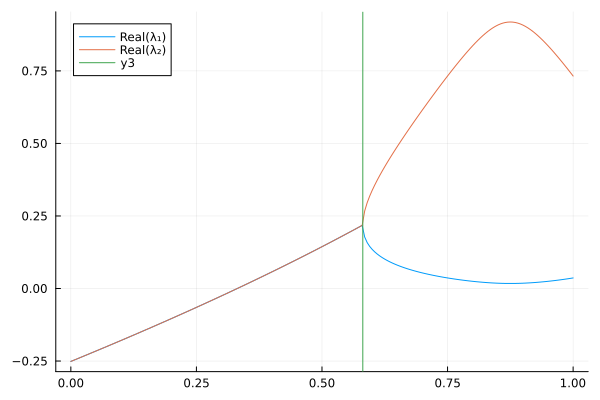

In [791]:
I_ext = 0.0:0.005:1.0
Λ = Eigenvalores.(I_ext)
Λ1 = [λ[1] for λ in Λ]
Λ2 = [λ[2] for λ in Λ]
plot(I_ext, Λ1, label = "Real(λ₁)")
plot!(I_ext, Λ2, label = "Real(λ₂)")
vline!([punto_estable(0.0)])

In [7]:
include("Librerias\\duales.jl")
include("Librerias\\integracion_taylor.jl");

In [788]:
using .DifAutom, .IntegTaylor

In [789]:
function f!(du,u,p,t)
    du[1] = u[1] - u[1]^3/3 - u[2] + p[1]*p[2]
    du[2] = (u[1] + p[3] - p[4]*u[2])/p[5]
end

f! (generic function with 1 method)

In [798]:
v0 = 1.0
w0 = 0.2
u0 = [v0,w0]

t_ini = 0.0
t_fin = 50.0

orden = 50
ϵ = 1e-10

I_ext = punto_estable(0.0)

0.5812657551242898

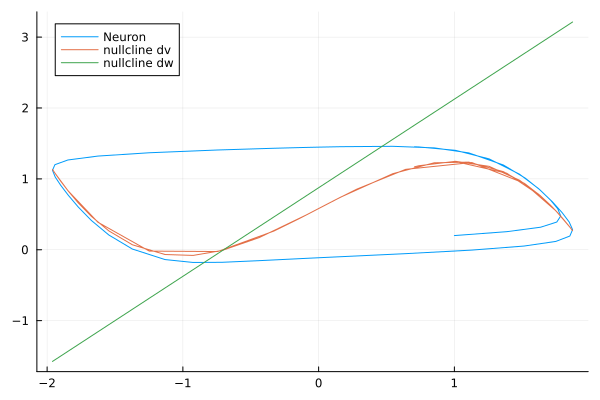

In [801]:
p = [R,I_ext,a,b,τ]

t,u = integracion_taylor(f!,u0,t_ini,t_fin,orden,ϵ,p)
v = [uu[1] for uu in u]
w = [uu[2] for uu in u]
plot(v,w,label="Neuron")
plot!(v,isoclina_dv.(v,I_ext), label = "nullcline dv")
plot!(v,isoclina_dw.(v), label = "nullcline dw")

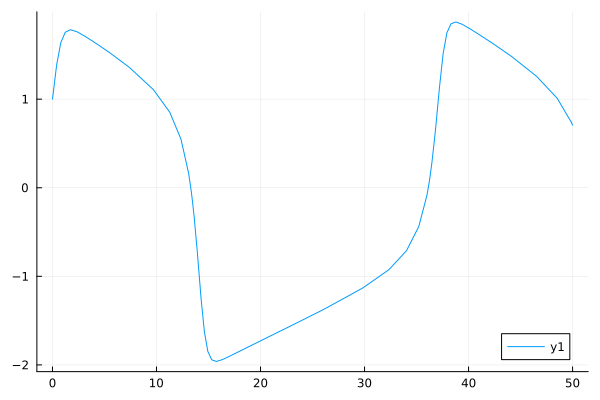

In [802]:
plot(t,v)

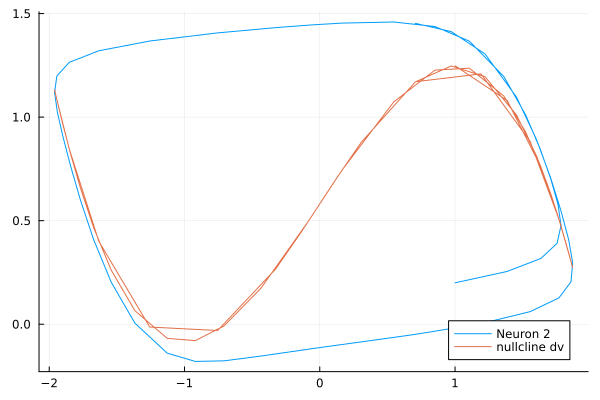

In [803]:
p = [R,I_ext + 1e-5,a,b,τ]

t,u = integracion_taylor(f!,u0,t_ini,t_fin,orden,ϵ,p)
v = [uu[1] for uu in u]
w = [uu[2] for uu in u]
plot(v,w,label="Neuron 2")
plot!(v,isoclina_dv.(v,I_ext), label = "nullcline dv")

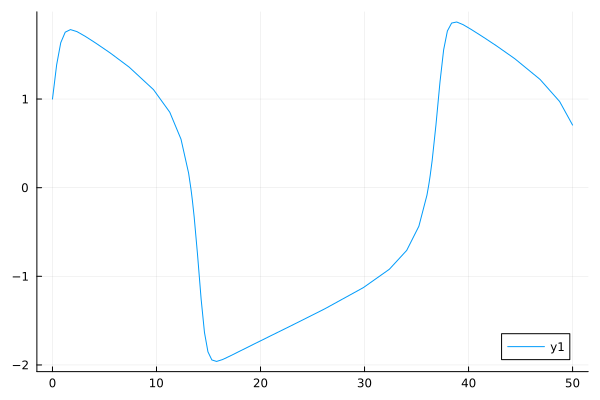

In [804]:
plot(t,v)

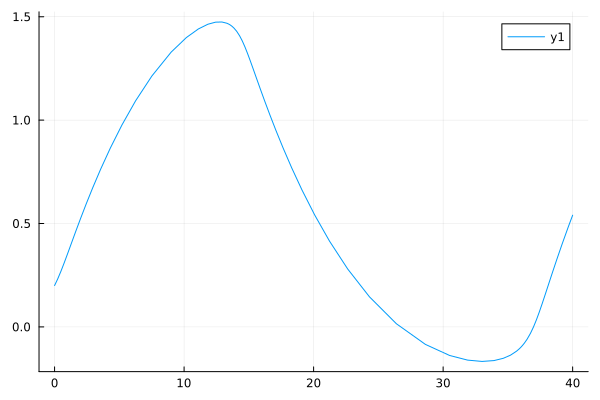

In [622]:
plot(t,w)

0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0


[ Info: Saved animation to C:\Users\cocol\Desktop\ProyectoFinal_TSFC2\tmp.gif


Plots.AnimatedGif("C:\\Users\\cocol\\Desktop\\ProyectoFinal_TSFC2\\tmp.gif")
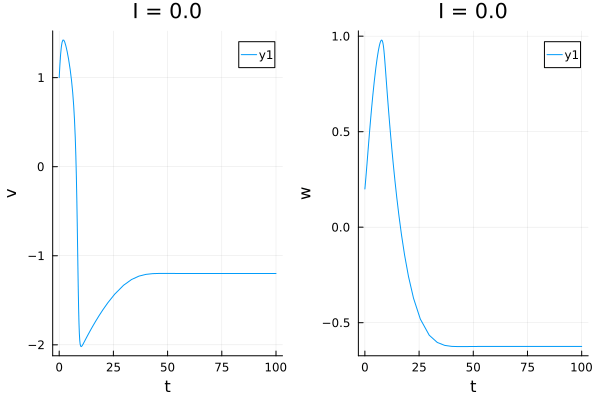

In [178]:
I = 0.0:0.05:1.0
@gif for i in I
    p = [R,i,a,b,τ]
    t_ini = 0.0
    t_fin = 100.0
    orden = 20
    ϵ = 1e-10
    t,u = integracion_taylor(f!,u0,t_ini,t_fin,orden,ϵ,p)
    v = [u[i][1] for i in 1:length(t)]
    w = [u[i][2] for i in 1:length(t)]
    vt = plot(t,v, title = "I = $(i)", ylabel = "v", xlabel="t")
    wt = plot(t,w, title = "I = $(i)", ylabel = "w", xlabel="t")
    plot(vt,wt)
    println(i)
end